In this notebook, we will explain how to use XMem, SAM, DINOv2 with our wrappers. The wrappers are designed to make it easy to perform downstream robotics tasks

In [1]:
import sys
import os

import h5py
import cv2
import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt

project_repo_folder = "."
# For XMem
sys.path.append(f"{project_repo_folder}/third_party/XMem")
sys.path.append(f"{project_repo_folder}/third_party/XMem/model")
sys.path.append(f"{project_repo_folder}/third_party/XMem/util")
sys.path.append(f"{project_repo_folder}/third_party/XMem/inference")
sys.path.append(f"{project_repo_folder}/")
from PIL import Image
from pathlib import Path
from groot_imitation.groot_algo import GROOT_ROOT_PATH
from groot_imitation.groot_algo.xmem_tracker import XMemTracker
from groot_imitation.groot_algo.misc_utils import get_annotation_path, get_first_frame_annotation, overlay_xmem_mask_on_image, depth_to_rgb, resize_image_to_same_shape, plotly_draw_seg_image, rotate_camera_pose
from groot_imitation.groot_algo.misc_utils import overlay_xmem_mask_on_image, add_palette_on_mask, VideoWriter, get_transformed_depth_img
from groot_imitation.groot_algo.o3d_modules import O3DPointCloud, convert_convention


from IPython.display import Video


[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /home/andang/anaconda3/envs/groot/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Example of XMem VOS
In this part, you will learn how to use:
1. xmem_tracker wrapper that makes it easy to process video streams in robotics domains
2. how to render videos with the VOS masks.  

In [2]:
# annotation_folder = f"{project_repo_folder}/datasets/annotations/example_demo"
# demo_file_name = f"{project_repo_folder}/datasets/example_demo.hdf5"
annotation_folder = f"{project_repo_folder}/datasets/annotations/demo_0"
demo_file_name = f"{project_repo_folder}/datasets/pick_up_the_orange_juice_and_place_it_in_the_basket_demo/demo_0.hdf5"


first_frame, first_frame_annotation = get_first_frame_annotation(annotation_folder)

# ************************ Most important part *******************************
xmem_tracker = XMemTracker(xmem_checkpoint=f'{project_repo_folder}/third_party/xmem_checkpoints/XMem.pth', device='cuda:0')
xmem_tracker.clear_memory()
# **************************************************************************

resized_images = []

with h5py.File(demo_file_name, "r") as f:
    images = f["data/demo_0/obs"]["agentview_rgb"][:]

for image in images:
    image = cv2.resize(image, (first_frame_annotation.shape[1], first_frame_annotation.shape[0]), interpolation=cv2.INTER_AREA)
    resized_images.append(image)

masks = xmem_tracker.track_video(resized_images, first_frame_annotation)


mask_file = os.path.join(annotation_folder, "video_masks.hdf5")

with h5py.File(demo_file_name, "r+") as f: # add agentview_masks
    f["data/demo_0/obs"].create_dataset("agentview_masks", data=np.stack(masks, axis=0))

with h5py.File(mask_file, "w") as f:
    f.create_group("data")
    f["data"].create_dataset("agentview_masks", data=np.stack(masks, axis=0))

with VideoWriter(video_path=annotation_folder, video_name="mask_only_video.mp4", fps=20, save_video=True) as video_writer:
    for mask, image in zip(masks, resized_images):
        new_mask_img = add_palette_on_mask(mask).convert("RGB")
        video_writer.append_image(np.array(new_mask_img))

with VideoWriter(video_path=annotation_folder, video_name="overlay_video.mp4", fps=20, save_video=True) as video_writer:
    for mask, image in zip(masks, resized_images):
        new_mask_img = overlay_xmem_mask_on_image(image, mask, use_white_bg=True)
        video_writer.append_image(np.array(new_mask_img))

# Video(os.path.join(annotation_folder, "overlay_video.mp4"), embed=True, width=500, height=500)

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Saved videos to ./datasets/annotations/demo_0/mask_only_video.mp4.
Saved videos to ./datasets/annotations/demo_0/overlay_video.mp4.


### Example of RGB-D reconstruction
In this part, you will learn how to use:
1. read in RGB-D image from an example dataset
2. reconstruct the point clouds of the images
3. load in the segmentation mask, reconstruct object-centric 3d point clouds

In [4]:
# example_demo_file = f"{project_repo_folder}/datasets/example_demo.hdf5"
example_demo_file = f"{project_repo_folder}/datasets/pick_up_the_orange_juice_and_place_it_in_the_basket_demo/demo_0.hdf5"

print("Reading the example demo file...")
idx = 0
with h5py.File(example_demo_file) as f:
    # convert_convention fucntion is to make sure that the arrays are saved as contiguous arrays, which is important to make rendering proper.
    print(f["data/demo_0/obs"].keys())
    rgb_image = convert_convention(f["data/demo_0/obs"]["agentview_rgb"][idx])
    depth_image = convert_convention(f["data/demo_0/obs"]["agentview_depth"][idx])
    mask_image = f["data/demo_0/obs"]["agentview_masks"][idx]
    camera_extrinsics = f["data/demo_0/obs"]["agentview_extrinsics"][idx]
    camera_intrinsics = f["data/demo_0/obs"]["agentview_intrinsics"][idx]
    print(f["data"].attrs.keys())
    print(f["data/demo_0/obs"].keys())
mask_image = resize_image_to_same_shape(mask_image, rgb_image)

Reading the example demo file...
<KeysViewHDF5 ['agentview_depth', 'agentview_extrinsics', 'agentview_intrinsics', 'agentview_masks', 'agentview_position', 'agentview_rgb', 'ee_ori', 'ee_pos', 'ee_states', 'eye_in_hand_depth', 'eye_in_hand_extrinsics', 'eye_in_hand_intrinsics', 'eye_in_hand_position', 'eye_in_hand_rgb', 'gripper_states', 'joint_states']>
<KeysViewHDF5 ['bddl_path', 'demo_name', 'env_args']>
<KeysViewHDF5 ['agentview_depth', 'agentview_extrinsics', 'agentview_intrinsics', 'agentview_masks', 'agentview_position', 'agentview_rgb', 'ee_ori', 'ee_pos', 'ee_states', 'eye_in_hand_depth', 'eye_in_hand_extrinsics', 'eye_in_hand_intrinsics', 'eye_in_hand_position', 'eye_in_hand_rgb', 'gripper_states', 'joint_states']>


In [5]:
with h5py.File(example_demo_file) as f:
    print(f'f["data"]: {f["data"]}')
    print(f'f["data"].keys(): {f["data"].keys()}')
    print(f'f["data/demo_0"].keys(): {f["data/demo_0"].keys()}')
    print(f'f["data/demo_0/actions"].shape (T,A): {np.array(f["data/demo_0/actions"]).shape}')
    
    print(f'f["data/demo_0/obs"].keys(): {f["data/demo_0/obs"].keys()}')
    print(f'f["data/demo_0/obs"]["agentview_rgb"].shape (T, H, W, 3): {f["data/demo_0/obs"]["agentview_rgb"].shape}')
    print(f'f["data/demo_0/obs"]["agentview_depth"].shape (T, H, W): {f["data/demo_0/obs"]["agentview_depth"].shape}')
    print(f'f["data/demo_0/obs"]["agentview_masks"].shape (T, H1, W1): {f["data/demo_0/obs"]["agentview_masks"].shape}')
    print(f'f["data/demo_0/obs"]["agentview_extrinsics"].shape (T, 4, 4): {f["data/demo_0/obs"]["agentview_extrinsics"].shape}')
    print(f'f["data/demo_0/obs"]["ee_states"].shape (T, 16): {f["data/demo_0/obs"]["ee_states"].shape}')
    print(f'f["data/demo_0/obs"]["gripper_states"].shape (T, 1): {f["data/demo_0/obs"]["gripper_states"].shape}')

f["data"]: <HDF5 group "/data" (1 members)>
f["data"].keys(): <KeysViewHDF5 ['demo_0']>
f["data/demo_0"].keys(): <KeysViewHDF5 ['actions', 'obs']>
f["data/demo_0/actions"].shape (T,A): (126, 7)
f["data/demo_0/obs"].keys(): <KeysViewHDF5 ['agentview_depth', 'agentview_extrinsics', 'agentview_intrinsics', 'agentview_masks', 'agentview_position', 'agentview_rgb', 'ee_ori', 'ee_pos', 'ee_states', 'eye_in_hand_depth', 'eye_in_hand_extrinsics', 'eye_in_hand_intrinsics', 'eye_in_hand_position', 'eye_in_hand_rgb', 'gripper_states', 'joint_states']>
f["data/demo_0/obs"]["agentview_rgb"].shape (T, H, W, 3): (126, 128, 128, 3)
f["data/demo_0/obs"]["agentview_depth"].shape (T, H, W): (126, 128, 128, 1)
f["data/demo_0/obs"]["agentview_masks"].shape (T, H1, W1): (126, 480, 480)
f["data/demo_0/obs"]["agentview_extrinsics"].shape (T, 4, 4): (126, 4, 4)
f["data/demo_0/obs"]["ee_states"].shape (T, 16): (126, 6)
f["data/demo_0/obs"]["gripper_states"].shape (T, 1): (126, 2)


[0 1 2]


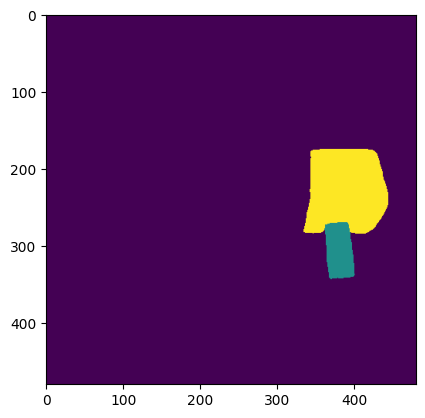

In [6]:
with h5py.File(example_demo_file) as f:
    plt.imshow(f["data/demo_0/obs"]["agentview_masks"][100])
    print(np.unique(f["data/demo_0/obs"]["agentview_masks"][100]))

Visualize what they look like:

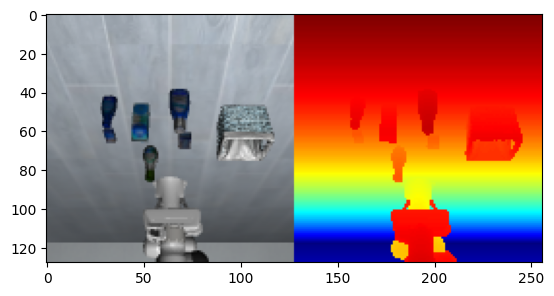

In [7]:
depth_image_in_rgb = depth_to_rgb(depth_image, colormap="jet") # You can visualize the depth with either jet, magma, viridis color map
# display the two images by simply concatenating them
plt.imshow(np.concatenate([rgb_image, depth_image_in_rgb], axis=1))

Visualize their 3d point clouds

In [8]:
# render 3d point cloud
import plotly
import plotly.graph_objs as go

depth_pc = O3DPointCloud()
depth_pc.create_from_depth(depth_image, camera_intrinsics)

depth_pc.transform(camera_extrinsics)
point_cloud = depth_pc.get_points()
x_vals = point_cloud[:, 0]
y_vals = point_cloud[:, 1]
z_vals = point_cloud[:, 2]

# Create the scatter3d plot
scatter = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=3, color=z_vals, colorscale='Viridis', opacity=0.8)
)

# Set the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Combine the scatter plot and layout to create a figure
fig = go.Figure(data=[scatter], layout=layout)

# Show the figure
fig.show()

In [9]:
rgbd_pc = O3DPointCloud()
rgbd_pc.create_from_rgbd(rgb_image, depth_image, camera_intrinsics)
rgbd_pc.transform(camera_extrinsics)

point_cloud = rgbd_pc.get_points()
colors_rgb = rgbd_pc.get_colors()
# Convert RGB colors to a format recognizable by Plotly
color_str = ['rgb('+str(r)+','+str(g)+','+str(b)+')' for r,g,b in colors_rgb]

# Extract x, y, and z columns from the point cloud
x_vals = point_cloud[:, 0]
y_vals = point_cloud[:, 1]
z_vals = point_cloud[:, 2]

# Create the scatter3d plot
rgbd_scatter = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=3, color=color_str, opacity=0.8)
)

# Set the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(data=[rgbd_scatter], layout=layout)

# Show the figure
fig.show()

In [17]:
from plotly.subplots import make_subplots

object_centric_scatters = []
print(mask_image.max())
for mask_idx in range(1, mask_image.max()+1):
    # crop the image and depth
    masked_depth_image = depth_image.copy()
    binary_mask = np.where(mask_image==mask_idx, 1, 0)
    masked_depth_image[binary_mask == 0] = -1

    object_pcd = O3DPointCloud()
    object_pcd.create_from_rgbd(rgb_image, masked_depth_image, camera_intrinsics)
    object_pcd.transform(camera_extrinsics)
    # object_pcd.preprocess()

    point_cloud = object_pcd.get_points()
    colors_rgb = object_pcd.get_colors()

    x_vals = point_cloud[:, 0]
    y_vals = point_cloud[:, 1]
    z_vals = point_cloud[:, 2]

    # Convert RGB colors to a format recognizable by Plotly
    color_str = ['rgb('+str(r)+','+str(g)+','+str(b)+')' for r,g,b in colors_rgb]
    scatter = go.Scatter3d(
        x=x_vals,
        y=y_vals,
        z=z_vals,
        mode='markers',
        marker=dict(size=3, color=color_str, opacity=0.8)
    )
    object_centric_scatters.append(scatter)


# Set the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(data=object_centric_scatters, layout=layout)

# Show the figure
fig.show()

2


#### Camera perspective augmentation

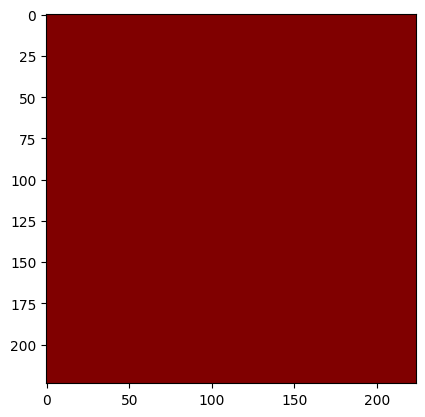

In [11]:
new_camera_extrinsics = rotate_camera_pose(camera_extrinsics, angle=-60, point=[0.6, 0, 0])

new_depth_img, z_max = get_transformed_depth_img(
    point_cloud=rgbd_pc.get_points(),
    camera_intrinsics=np.array(camera_intrinsics),
    new_camera_extrinsics=new_camera_extrinsics,
    camera_width=224,
    camera_height=224,
)

plt.imshow(depth_to_rgb(new_depth_img, colormap="jet"))

### Example of Segment Correspondence Model
In this part, you will learn how to use:
1. get a segmentation of the image using SAM
2. load a reference image, and compute DINOv2 feature using our DINOv2 wrapper
3. interactively visualize DINOv2 cost volume (may need to use jupyter-dash)
4. get the correspondence

In [12]:
from groot_imitation.groot_algo.sam_operator import SAMOperator
from groot_imitation.groot_algo.dino_features import DinoV2ImageProcessor, compute_affinity, rescale_feature_map, generate_video_from_affinity

dinov2 = DinoV2ImageProcessor()
sam_operator = SAMOperator()
sam_operator.print_config()
sam_operator.init()

{'output_dir': '', 'opts': [], 'pretrained_weights': 'https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth', 'config_file': '/home/andang/workspace/mmint/neurips_2025/GROOT/groot_imitation/groot_algo/../../third_party/dinov2/dinov2/configs/eval/vitb14_pretrain.yaml'}
I20250505 22:39:49 57833 dinov2 config.py:60] git:
  sha: fc49f49d734c767272a4ea0e18ff2ab8e60fc92d, status: clean, branch: HEAD

I20250505 22:39:49 57833 dinov2 config.py:61] config_file: /home/andang/workspace/mmint/neurips_2025/GROOT/groot_imitation/groot_algo/../../third_party/dinov2/dinov2/configs/eval/vitb14_pretrain.yaml
opts: ['train.output_dir=/home/andang/workspace/mmint/neurips_2025/GROOT']
output_dir: /home/andang/workspace/mmint/neurips_2025/GROOT
pretrained_weights: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth
I20250505 22:39:49 57833 dinov2 config.py:27] sqrt scaling learning rate; base: 0.004, new: 0.001
I20250505 22:39:49 57833 dinov2 config.py:34]

In [13]:
import torch
from functools import partial
# autocast_dtype = torch.half
# autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=autocast_dtype)
# with autocast_ctx():
#     with torch.no_grad():
mask_result_dict = sam_operator.segment_image(rgb_image)

<segment_anything.automatic_mask_generator.SamAutomaticMaskGenerator object at 0x7b7a78ed5e70> <bound method SamAutomaticMaskGenerator.generate of <segment_anything.automatic_mask_generator.SamAutomaticMaskGenerator object at 0x7b7a78ed5e70>>


In [14]:
# visaualize the mask using plotly
import plotly
import plotly.express as px
overall_mask = (mask_result_dict["overall_mask"] * 255).astype(np.uint8)
mask_ids = mask_result_dict["merged_mask"]
# draw the mask image in plotly canvas
fig = px.imshow(overall_mask)

fig.data[0].customdata = mask_ids
# fig.data[0].hovertemplate = '<b>Mask ID:</b> %{customdata}'
fig.data[0].hovertemplate = 'x: %{x}<br>y: %{y}<br>Mask ID: %{customdata}'


fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    showlegend=False,
    width=300,   # you can adjust this as needed
    height=300,   # you can adjust this as needed
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()


In [15]:
new_instance_image = np.array(Image.open(os.path.join(GROOT_ROOT_PATH, "../", "datasets", "annotations/example_demo/example_new_object.jpg")))
new_instance_image = resize_image_to_same_shape(new_instance_image, rgb_image)

img_list = []
feature_list = []
for img in [rgb_image, new_instance_image]:
    img_list.append(img)
    feature_list.append(dinov2.process_image(img))

saved_video_file = generate_video_from_affinity(
    img_list[0], 
    img_list[1], 
    feature_list[0], 
    feature_list[1],
    h=32,
    w=32,
    patch_size=14,
    )
# display the video
# Video(saved_video_file, embed=True, width=500, height=500)


Saved videos to ././dinov2_tmp_video.mp4.


### SCM Model example

In [16]:
from groot_imitation.segmentation_correspondence_model.scm import SegmentationCorrespondenceModel

scm_module = SegmentationCorrespondenceModel(dinov2=dinov2, sam_operator=sam_operator)

new_annotation_mask = scm_module(new_instance_image, rgb_image, mask_image)
new_annotation_mask = resize_image_to_same_shape(new_annotation_mask, new_instance_image)
print(new_instance_image.shape, new_annotation_mask.shape)
new_instance_overlay_image = overlay_xmem_mask_on_image(new_instance_image, new_annotation_mask, use_white_bg=True)

plotly_draw_seg_image(new_instance_overlay_image, new_annotation_mask)


<segment_anything.automatic_mask_generator.SamAutomaticMaskGenerator object at 0x7b7a78ed5e70> <bound method SamAutomaticMaskGenerator.generate of <segment_anything.automatic_mask_generator.SamAutomaticMaskGenerator object at 0x7b7a78ed5e70>>
(128, 128, 3) (128, 128)
